# Explore PICO data

In [66]:
# generic imports
import ast
import collections
import re
import spacy
import scispacy
import time
import numpy as np
from collections import Counter
from itertools import groupby
import itertools
from operator import itemgetter
import csv
import errno
import os
import sqlite3
import string
from collections import defaultdict
from sqlite3 import Error

# DS imports
import pandas as pd
import numpy as np

# visualiation imports 
from matplotlib_dashboard import MatplotlibDashboard
import matplotlib.pyplot as plt
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
import seaborn as sns

# NLP imports
import spacy
from nltk.stem import PorterStemmer
from spellchecker import SpellChecker
import contextualSpellCheck

# Sklearn imports
from sklearn.model_selection import train_test_split

In [4]:
#loading the english language small model of spacy
en = spacy.load('en_core_sci_scibert')

random_seed = 0

In [67]:
# add spellchecker to pipeline

en.add_pipe("contextual spellchecker")

In [5]:
load_data = '/mnt/nas2/data/systematicReview/semeval2023/data/parsed/st2_train_parsed.tsv'

In [6]:
df = pd.read_csv(load_data, sep='\t')
print(df.shape)

(597, 10)


In [7]:
# Remove empty reddit posts

df_clean = df[~df['claim_offsets'].str.contains('N.A.')]
print(df_clean.shape)

(522, 10)


In [8]:
df_clean.head()

,Unnamed: 0,post_id,subreddit_id,claim,stage2_labels,text,labels_char,claim_offsets,tokens,labels
0,0,sn9u41,t5_2s23e,I read an old thread on here that someone said...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Tysabri experiences\nHi all\n\nI just had my 3...,"[2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","(508, 724)","['Tysabri', 'experiences', 'Hi', 'all', 'I', '...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,p7j49y,t5_2syer,"I have read that gout can't be cured, that it'...","[{""crowd-entity-annotation"":{""entities"":[{""end...",Crazy amount of sardines caused gout (possibly...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1401, 1654)","['Crazy', 'amount', 'of', 'sardines', 'caused'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,smgy0q,t5_2s3g1,I always read stories of people who suffer fro...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Im sorry for intruding but I just want to say ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(302, 419)","['Im', 'sorry', 'for', 'intruding', 'but', 'I'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,sxglhl,t5_2s3g1,Our results indicate that the addition of prob...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Is Bacillus coagulans supplementation plus low...,"[0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","(1442, 1617)","['Is', 'Bacillus', 'coagulans', 'supplementati...","[0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, ..."
6,6,sfc8e0,t5_2tyg2,"Here it says, in the DSM book","[{""crowd-entity-annotation"":{""entities"":[]}}]",Psychosis (as its described now) doesnt really...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1568, 1597)","['Psychosis', '(as', 'its', 'described', 'now)...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
picos_mapping = {'population': 1, 'intervention':2, 'outcome':3, 'oos':0}

### Reddit post lengths

In [10]:
lengths = [ len( ast.literal_eval(i)) for i in df_clean.tokens ]

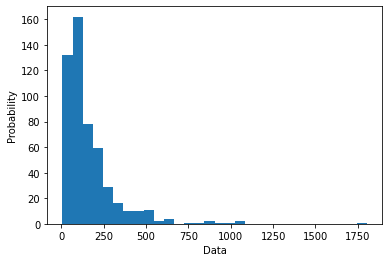

In [11]:
plt.hist(lengths, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

### class vs out-of-the-class tokens

In [12]:
def class_ratio(labels, entity):
    
    entity_num = picos_mapping[entity]
    
    out_of_span_counter = 0
    class_counter = 0
    
    for i in labels:
        lab_i = ast.literal_eval(i)
        if len(lab_i)>1:
            counts = collections.Counter( lab_i )
            counts = dict( counts )
            out_of_span_counter = out_of_span_counter + counts[0]
            if entity_num in counts:
                class_counter = class_counter + counts[entity_num]
                
    count_summary = {str(entity): class_counter, 'oos':out_of_span_counter}
                
    return count_summary

{'population': 469, 'oos': 82592}
{'intervention': 882, 'oos': 82592}
{'outcome': 879, 'oos': 82592}


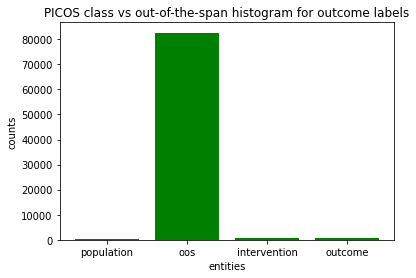

In [13]:
for x in [ 'population', 'intervention', 'outcome' ]:
    count_summary = class_ratio(df_clean.labels, x)
    print( count_summary )
    plt.bar(list(count_summary.keys()), count_summary.values(), color='g')
    plt.title(f'PICOS class vs out-of-the-span histogram for {x} labels')
    plt.xlabel('entities')
    plt.ylabel('counts')

### Inspect the PICO annotations

In [14]:
picos_colors_mapping = {'population': 'green', 'intervention': 'red', 'outcome': 'blue', 'oos':'black'}

In [15]:
def inspect_annots(entity, df_):
    terms_all = []
    terms_lengths = []

    for counter, (tok, lab) in enumerate(zip(df_.tokens.values, df_.labels.values)):
        
        tok = ast.literal_eval(tok)
        lab = ast.literal_eval(lab)
        
        
        captured_ind = []
        captured_cons_ind = []
        for counter_i, (t, l) in  enumerate(zip(tok, lab)):
            if l == picos_mapping[entity]:
                captured_ind.append( counter_i )

        for k, g in groupby(enumerate(captured_ind), lambda ix : ix[0] - ix[1]):
            label_indices = list(map(itemgetter(1), g))
            captured_cons_ind.append( label_indices )

        #print('\n-----------------------------------------------')

        for x in captured_cons_ind:
            #print(x)
            p_term = [tok[x_i] for x_i in x]
            terms_lengths.append( len(p_term) )
            p_term = ' '.join(p_term)
            terms_all.append( p_term )
            
            
    return terms_lengths, terms_all

In [16]:
def plot_common_words(description_list, n):
    # Assign the Counter instance `most_common` call to a variable:
    word_frequency = Counter(" ".join(description_list).split()).most_common(n)

    # `most_common` returns a list of (word, count) tuples
    words = [word for word, _ in word_frequency]
    counts = [counts for _, counts in word_frequency]
    
    fig = plt.figure(figsize=(7, 5))
    plt.bar(words, counts, color = picos_colors_mapping[picos_i])
    plt.title("10 most frequent tokens in the list")
    plt.ylabel("Frequency")
    plt.xlabel("Words")
    plt.xticks(rotation=45, ha='right')

    plt.show()

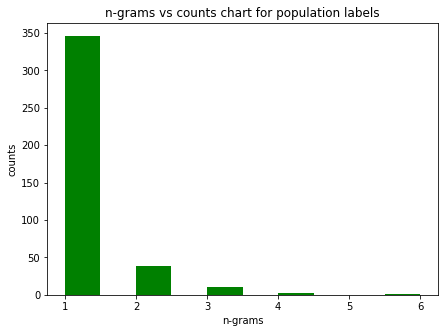

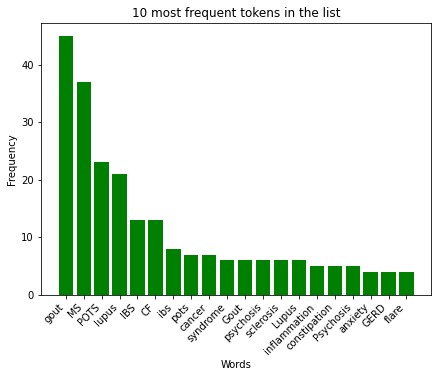

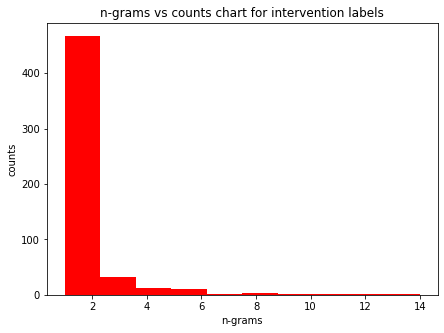

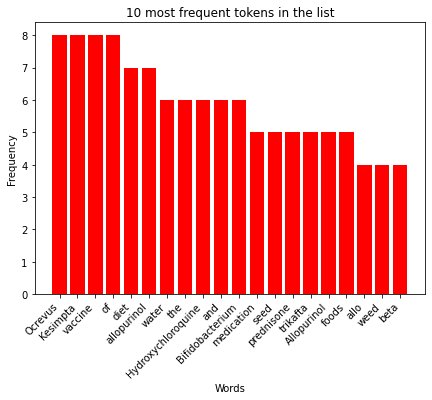

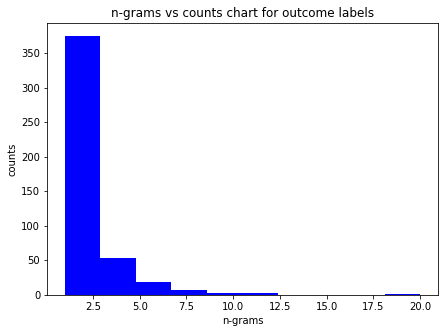

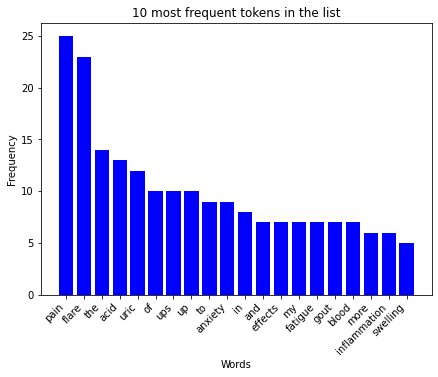

In [17]:
for picos_i in [ 'population', 'intervention', 'outcome' ]:
    
    terms_i_lengths, terms_i_all = inspect_annots(picos_i, df_clean)   

    fig = plt.figure(figsize=(7, 5))
    plt.hist( terms_i_lengths, bins=10, color = picos_colors_mapping[picos_i]) 
    plt.title(f'n-grams vs counts chart for {picos_i} labels')
    plt.xlabel('n-grams')
    plt.ylabel('counts')
        
    plt.show()
    
    plot_common_words(terms_i_all, 20)

Some notes: <br>

Participants: Lots of abbreviations. Consider them in the training and could use that in augmentation.

### Class overlap

In [18]:
def class_overlap(tokens, labels):
    
    par = []
    inter = []
    out = []
    oos = []
    
    for t, l in zip(tokens, labels):
        tok_i = ast.literal_eval(t)
        lab_i = ast.literal_eval(l)
        
        if len(lab_i)>1:
            
            for i,j in zip(tok_i, lab_i):
                if j == 0:
                    oos.append(i)
                if j == 1:
                    par.append(i)
                if j == 2:
                    inter.append(i)
                if j == 3:
                    out.append(i)

    return { 'participant': par, 'intervention': inter, 'outcome': out, 'oos': oos }


tokens_dict = class_overlap(df_clean.tokens, df_clean.labels)

In [95]:
for pair in itertools.combinations(['participant','intervention','outcome','oos'], 2):
    
    t1 = tokens_dict[ pair[0] ]
    t2 = tokens_dict[ pair[1] ]
    
    common = list(set(t1).intersection(t2))
    #print( f'Common tokens between {pair[0]} and {pair[1]}: {common} \n' )
    #print( f'Total number of common tokens between {pair[0]} and {pair[1]}: {len(common)} \n' )
    #print(' -------------------------------------------------------------------- ')

### POS tag distributions

In [20]:
from spacy.glossary import GLOSSARY
lookup_dict = GLOSSARY

In [96]:
#lookup_dict

In [22]:
pos_2_num = dict( zip(lookup_dict.keys(), [*range(len(lookup_dict))]) )

In [50]:
def getPOStags(value):
    
    value = ast.literal_eval(value)
    pos = []
    
    for v in value:
        if type(v) == str:
            doc = en(v)
            tok_pos = [ token.tag_ for token in doc ]
            pos.append( tok_pos[0] )
        else:
            pos.append( 'N.A.' )

    return pos

def getPOSCoarsetags(value):
    
    value = ast.literal_eval(value)
    pos = []
    
    for v in value:
        if type(v) == str:
            doc = en(v)
            tok_pos = [ token.pos_ for token in doc ]
            pos.append( tok_pos[0] )
        else:
            pos.append( 'N.A.' )

    return pos

In [51]:
df_clean['pos'] = df_clean.tokens.progress_apply(getPOSCoarsetags)

  0%|          | 0/522 [00:00<?, ?it/s]

<ipython-input-51-82048b31a2f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['pos'] = df_clean.tokens.progress_apply(getPOSCoarsetags)


In [24]:
df_clean['pos_fine'] = df_clean.tokens.progress_apply(getPOStags)

  0%|          | 0/522 [00:00<?, ?it/s]

<ipython-input-24-eecf2b10fe2d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['pos'] = df_clean.tokens.progress_apply(getPOStags)


In [25]:
def get_pos_distribution(pos, lab, ent):
    
    pos_ent = []
    
    for p, j in zip( pos, lab ):
            
        #p = ast.literal_eval(i)
        l = ast.literal_eval(j)
    
        for p_i, l_i in zip(p, l):
            if l_i == picos_mapping[ent]:
                pos_ent.append( p_i )
    
    pos_counts = collections.Counter(pos_ent)
    pos_counts = dict( pos_counts.most_common(10) )
    
    fig = plt.figure(figsize=(12, 5))
    plt.bar(pos_counts.keys(), pos_counts.values(), color = picos_colors_mapping[ent])
    plt.title(f'POS tags counts in the {ent} class')
    plt.ylabel("Counts")
    plt.xlabel("POS tags")
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    # Distribution
    # create figure and axes
    pos_ent_num = [pos_2_num[i] for i in pos_ent]
    graph = sns.displot( data=pos_ent_num, stat='count', height=4, aspect=1.5, kde=True )
    
    return pos_counts

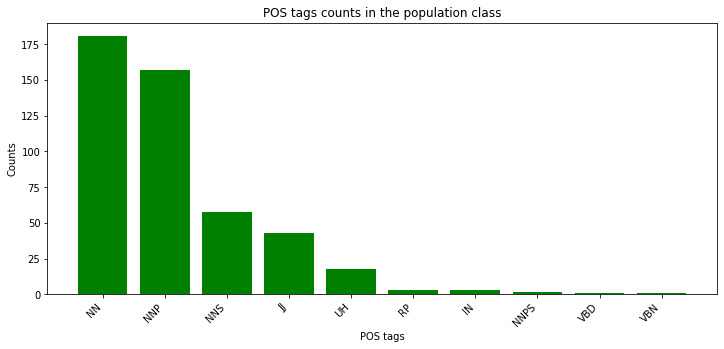

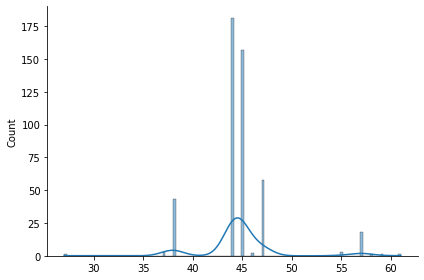

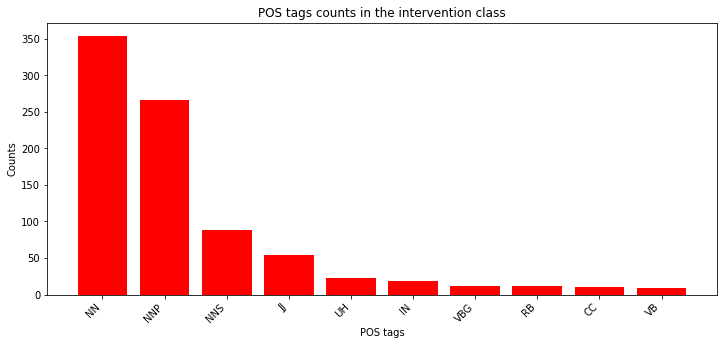

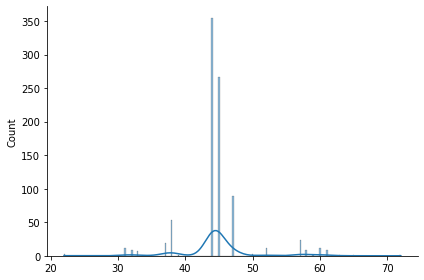

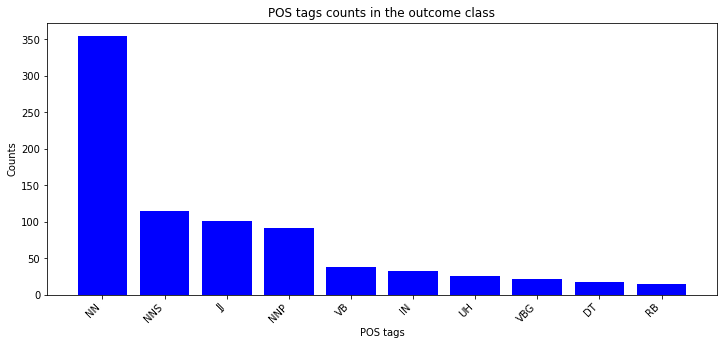

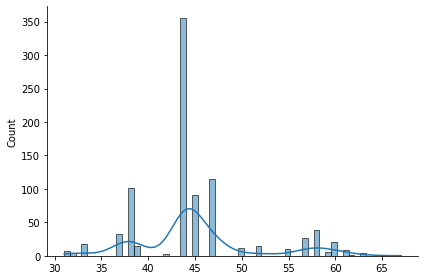

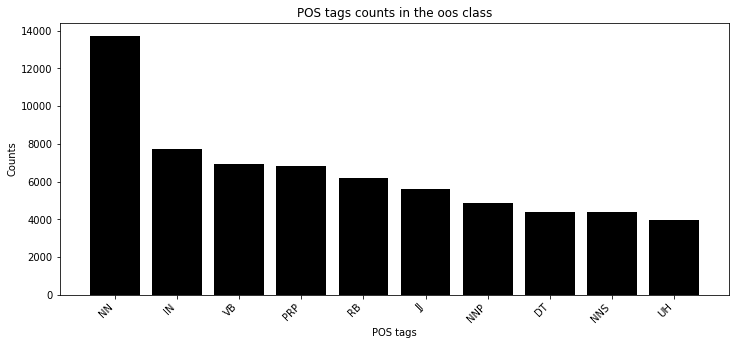

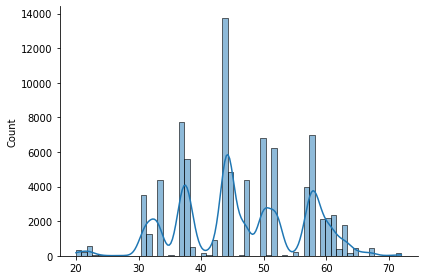

In [26]:
for i in ['population', 'intervention', 'outcome','oos']:
    get_pos_distribution( df_clean.pos, df_clean.labels , i )

Notes: POS tag distributions are different/discriminatory for the PICO tags

### Examine individual PICO

In [97]:
for picos_i in [ 'outcome' ]:
    
    _, terms_i_all = inspect_annots(picos_i, df_clean)
    
    #for i in list(set(terms_i_all)):
        #print(i)

### Examine social media posts

In [28]:
df_clean.shape

(522, 11)

In [99]:
#for i in df_clean.tokens:
    #print(i)
    #print('-------------------------------')

### Divide the df into training and validation set

In [30]:
train_df, val_df = train_test_split(df_clean, shuffle=False, random_state=random_seed)

In [31]:
# Use validation set directory to build models
participant_labels = []
intervention_labels = []
outcome_labels = []

for picos_i in [ 'population', 'intervention', 'outcome' ]:
    
    terms_i_lengths, terms_i_all = inspect_annots(picos_i, df_clean)
    for t in terms_i_all:
        if picos_i == 'population':
            participant_labels.append(t)
        if picos_i == 'intervention':
            intervention_labels.append(t)
        if picos_i == 'outcome':
            outcome_labels.append(t)

### Lemma, Stemming, other info

In [34]:
def getLemma(value):
    
    value = ast.literal_eval(value)
    lemma = []
    
    for v in value:
        if type(v) == str:
            doc = en(v)
            tok_lemma = [ token.lemma_ for token in doc ]
            lemma.append( tok_lemma[0] )
        else:
            lemma.append( 'N.A.' )

    return lemma

In [35]:
df_clean['lemma'] = df_clean.tokens.progress_apply(getLemma)

  0%|          | 0/522 [00:00<?, ?it/s]

<ipython-input-35-05a4a1abbb9b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['lemma'] = df_clean.tokens.progress_apply(getLemma)


In [87]:
df_clean.head()

,Unnamed: 0,post_id,subreddit_id,claim,stage2_labels,text,labels_char,claim_offsets,tokens,labels,pos_fine,lemma,pos
0,0,sn9u41,t5_2s23e,I read an old thread on here that someone said...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Tysabri experiences\nHi all\n\nI just had my 3...,"[2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","(508, 724)","['Tysabri', 'experiences', 'Hi', 'all', 'I', '...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[NNP, NNS, UH, NNP, PRP, RB, VBD, UH, NN, NNP,...","[Tysabri, experience, hi, all, I, just, have, ...","[PROPN, NOUN, INTJ, PROPN, PRON, ADV, VERB, IN..."
1,1,p7j49y,t5_2syer,"I have read that gout can't be cured, that it'...","[{""crowd-entity-annotation"":{""entities"":[{""end...",Crazy amount of sardines caused gout (possibly...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1401, 1654)","['Crazy', 'amount', 'of', 'sardines', 'caused'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[JJ, NN, IN, NNP, VBN, NN, -LRB-, JJ, UH, IN, ...","[crazy, amount, of, sardines, cause, gout, (, ...","[ADJ, NOUN, ADP, PROPN, VERB, NOUN, PUNCT, ADJ..."
2,2,smgy0q,t5_2s3g1,I always read stories of people who suffer fro...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Im sorry for intruding but I just want to say ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(302, 419)","['Im', 'sorry', 'for', 'intruding', 'but', 'I'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[UH, JJ, IN, VBG, CC, PRP, RB, VB, VB, VB, WRB...","[i, sorry, for, intrude, but, I, just, want, t...","[INTJ, ADJ, ADP, VERB, CCONJ, PRON, ADV, VERB,..."
3,3,sxglhl,t5_2s3g1,Our results indicate that the addition of prob...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Is Bacillus coagulans supplementation plus low...,"[0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","(1442, 1617)","['Is', 'Bacillus', 'coagulans', 'supplementati...","[0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, ...","[VBZ, NNP, NNS, NN, CC, JJ, NNP, NN, JJ, VB, J...","[be, Bacillus, coagulan, supplementation, plus...","[VERB, PROPN, NOUN, NOUN, CCONJ, ADJ, PROPN, N..."
6,6,sfc8e0,t5_2tyg2,"Here it says, in the DSM book","[{""crowd-entity-annotation"":{""entities"":[]}}]",Psychosis (as its described now) doesnt really...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1568, 1597)","['Psychosis', '(as', 'its', 'described', 'now)...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[NN, -LRB-, PRP, VBN, RB, VBZ, RB, VB, IN, PRP...","[psychosis, (, its, describe, now, do, really,...","[NOUN, PUNCT, PRON, VERB, ADV, VERB, ADV, VERB..."


### UMLS inspection

In [38]:
'''
Description:
    Creates a database connection to the SQLite database specified by the db_file

Args:
    db_file (str): Path to the SQLite database 

Returns:
    conn (str): Connection object or None
'''
def createMySQLConn(db_file):

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print('This is the connection: ', conn)
    except Error as e:
        print(e)

    return conn

In [39]:
'''
Description:
    This function selects all rows from UMLS.db for the chosen pico_category.

Args:
    conn (Connection) : MySQL connection to the preprocessed UMLS.db 
    pico_category (str): choice for the entitiy type to retrieve appropriate UMLS concepts from UMLS.db

Returns:
    rows (list): Selected terms (and their SAB label) for  pico_category
'''
def selectTerminology(conn):
    """
    Query all rows in the tasks table
    :param conn: the Connection object
    :return:
    """

    cur = conn.cursor()
    
    cur.execute("SELECT TERM_PRE, STY FROM terminology1")
    results = cur.fetchall()
    
    return results

In [40]:
umls = dict()
indir = '/mnt/nas2/data/systematicReview'
fpath = 'UMLS/english_subset/umls_preprocessed/umls_tui_pios4_.db'
umls_fpath = f'{indir}/{fpath}'
conn = createMySQLConn( umls_fpath )

This is the connection:  <sqlite3.Connection object at 0x7fb899707210>


In [41]:
results = selectTerminology(conn)

In [42]:
def map_to_sty(p):
    
    term2sty=dict()
    
    for p_i in p:
        if p_i[1] not in term2sty:
            term2sty[ p_i[1] ] = [ p_i[0].lower() ]
        else:
            term2sty[ p_i[1] ].append( p_i[0].lower() )
            
    return term2sty

term_lookup = map_to_sty(results)

In [43]:
def get_ent_sty_lookup(d_labels):
    
    d_2_sty = dict()
    
    for x in d_labels:
        for k, v in term_lookup.items():
            if x.lower() in v:
                if x not in d_2_sty or x.lower():
                    d_2_sty[x.lower()] = [k]
                else:
                    d_2_sty[x.lower()].append(k)
    
    return d_2_sty

In [101]:
participant_labels = list(set(participant_labels))
intervention_labels = list(set(intervention_labels))
outcome_labels = list(set(outcome_labels))

umls_coverage = dict()

for d_labels, picos_i in zip( [ participant_labels, intervention_labels, outcome_labels ], ['population', 'intervention', 'outcome'] ):
    
    pico_2_sty = get_ent_sty_lookup(d_labels)
    umls_coverage[picos_i] = pico_2_sty
    
    print(' ----------------------------------------------------------------  ')
    print( f'\n{picos_i} class terms without any semantic group: \n' )
    for x in d_labels:
        if x.lower() not in pico_2_sty:
            print( x )

 ----------------------------------------------------------------  

population class terms without any semantic group: 

MV470v
CFLD
baby with CF
LPR/GERD
IBS-C
schizophrenic.
asymptomatic newborns with CF
pelvic spasms
gastrointestinal motility disorders
SIB0
alcohol neuropathy
immune compromised
Plantar Fasciittis
allergic to vaccines
pylori
UCTD/lupus
partial bowel dysmotility
CFRD
common gastrointestinal diagnoses
*POTS
DPDR
flare up
CFers
hashimotos
Covid-19
bad flare
irritable bowel syndrome management
certain diet
healthy individuals
generalized epilepsy patients
RRMS
Hashimotos
DID
IBS patients
COVID-19
SPMS
people with pre-existing mental health conditions
Intestinal Fungal Dysbiosis
IBS-D
Busitus
Kaftrio
gout/Uric Acid
Visceral Hypersensitivity
R75q
 ----------------------------------------------------------------  

intervention class terms without any semantic group: 

Bellerica
FODMAP
adjust enzyme
spinal lesions
HH surgery
mild exercise
over the counter ointments
colchic

In [45]:
for k, v in umls_coverage.items():
    
    if k == 'population':
        coverage = ( len(v) / len(participant_labels) ) * 100
        print(f'For the {k} class, the UMLS coverage is: {coverage}')
    if k == 'intervention':
        coverage = ( len(v) / len(intervention_labels) ) * 100
        print(f'For the {k} class, the UMLS coverage is: {coverage}')
    if k == 'outcome':
        coverage = ( len(v) / len(outcome_labels) ) * 100
        print(f'For the {k} class, the UMLS coverage is: {coverage}')

For the population class, the UMLS coverage is: 59.411764705882355
For the intervention class, the UMLS coverage is: 58.133971291866025
For the outcome class, the UMLS coverage is: 52.47813411078717


In [46]:
umls_coverage.keys()

dict_keys(['population', 'intervention', 'outcome'])

In [104]:
df_clean.head()

,Unnamed: 0,post_id,subreddit_id,claim,stage2_labels,text,labels_char,claim_offsets,tokens,labels,pos_fine,lemma,pos
0,0,sn9u41,t5_2s23e,I read an old thread on here that someone said...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Tysabri experiences\nHi all\n\nI just had my 3...,"[2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","(508, 724)","['Tysabri', 'experiences', 'Hi', 'all', 'I', '...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[NNP, NNS, UH, NNP, PRP, RB, VBD, UH, NN, NNP,...","[Tysabri, experience, hi, all, I, just, have, ...","[PROPN, NOUN, INTJ, PROPN, PRON, ADV, VERB, IN..."
1,1,p7j49y,t5_2syer,"I have read that gout can't be cured, that it'...","[{""crowd-entity-annotation"":{""entities"":[{""end...",Crazy amount of sardines caused gout (possibly...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1401, 1654)","['Crazy', 'amount', 'of', 'sardines', 'caused'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[JJ, NN, IN, NNP, VBN, NN, -LRB-, JJ, UH, IN, ...","[crazy, amount, of, sardines, cause, gout, (, ...","[ADJ, NOUN, ADP, PROPN, VERB, NOUN, PUNCT, ADJ..."
2,2,smgy0q,t5_2s3g1,I always read stories of people who suffer fro...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Im sorry for intruding but I just want to say ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(302, 419)","['Im', 'sorry', 'for', 'intruding', 'but', 'I'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[UH, JJ, IN, VBG, CC, PRP, RB, VB, VB, VB, WRB...","[i, sorry, for, intrude, but, I, just, want, t...","[INTJ, ADJ, ADP, VERB, CCONJ, PRON, ADV, VERB,..."
3,3,sxglhl,t5_2s3g1,Our results indicate that the addition of prob...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Is Bacillus coagulans supplementation plus low...,"[0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","(1442, 1617)","['Is', 'Bacillus', 'coagulans', 'supplementati...","[0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, ...","[VBZ, NNP, NNS, NN, CC, JJ, NNP, NN, JJ, VB, J...","[be, Bacillus, coagulan, supplementation, plus...","[VERB, PROPN, NOUN, NOUN, CCONJ, ADJ, PROPN, N..."
6,6,sfc8e0,t5_2tyg2,"Here it says, in the DSM book","[{""crowd-entity-annotation"":{""entities"":[]}}]",Psychosis (as its described now) doesnt really...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1568, 1597)","['Psychosis', '(as', 'its', 'described', 'now)...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[NN, -LRB-, PRP, VBN, RB, VBZ, RB, VB, IN, PRP...","[psychosis, (, its, describe, now, do, really,...","[NOUN, PUNCT, PRON, VERB, ADV, VERB, ADV, VERB..."


### Write to dir

In [47]:
write_dir = '/mnt/nas2/data/systematicReview/semeval2023/data/preprocessed'
write_train = 'st2_train_preprocessed.tsv'
write_val = 'st2_val_preprocessed.tsv'

In [107]:
train_df, val_df = train_test_split(df_clean, test_size=0.1, shuffle=False, random_state=random_seed)

In [108]:
train_df.to_csv(f"{write_dir}/{write_train}", sep = "\t")
val_df.to_csv(f"{write_dir}/{write_val}", sep = "\t")